<a href="https://colab.research.google.com/github/jla524/cars-classification/blob/master/cars_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import os
import csv
import math
import glob
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive, files

import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Parameters

In [2]:
BATCH_SIZE = 16
EPOCHS = 15
steps_per_epoch =  50

## Prepare the data

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the images using glob

data_path = '/content/drive/My Drive/31559-46697-bundle-archive/'
train_path = data_path + 'car_data/car_data/train/'
test_path = data_path + 'car_data/car_data/test/'

X_train = [f for f in glob.glob(train_path + '**/*.jpg', recursive=True)]
X_test = [f for f in glob.glob(test_path + '**/*.jpg', recursive=True)]

In [5]:
# Load the image description 

columns = ['image_file', 'bbox1', 'bbox2', 'bbox3', 'bbox4', 'class_number']

y_train = pd.read_csv(data_path + 'anno_train.csv', names=columns)
y_test = pd.read_csv(data_path + 'anno_test.csv', names=columns)

## Explor the data

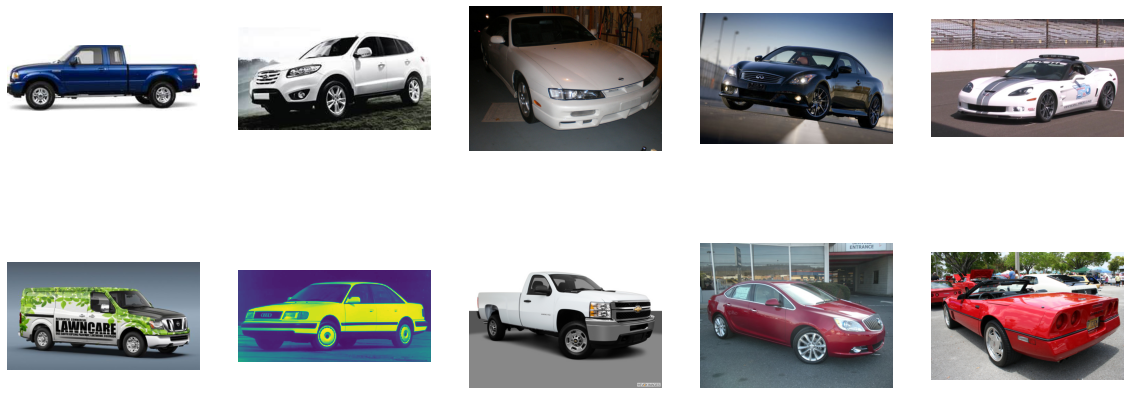

In [6]:
# Parameters for our graph; we'll output images in a 2x5 configuration
nrows = 2
ncols = 5

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# Randomly select 16 images to display
pix = []

for i in range(nrows * ncols):
    randint = random.randrange(len(X_train))
    pix.append(X_train[randint])

    
for i, img_path in enumerate(pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## Define the model

In [7]:
model = tf.keras.Sequential(
  [   tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same', input_shape=(150, 150, 3)),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.17),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, strides=2, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.17),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, strides=2, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.17),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(500, use_bias=False),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.28),
      
      tf.keras.layers.Dense(196, activation='softmax')
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 12)      324       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 12)      36        
_________________________________________________________________
activation (Activation)      (None, 150, 150, 12)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 12)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 24)        0

## Compile the model

In [8]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

## Training the model from generators

In [9]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
 
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_path,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128)

Found 8144 images belonging to 196 classes.


## Learning rate decay

In [10]:
# lr decay function
def lr_decay(epoch):
    return 0.01 * math.pow(0.77, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

## Do the training

In [11]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    callbacks=[lr_decay_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/15
50/50 [==============================] - 59s 1s/step - loss: 6.0819 - acc: 0.0091

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0077.
Epoch 2/15
50/50 [==============================] - 62s 1s/step - loss: 5.2403 - acc: 0.0236

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005929.
Epoch 3/15
50/50 [==============================] - 61s 1s/step - loss: 4.8009 - acc: 0.0595

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00456533.
Epoch 4/15
50/50 [==============================] - 60s 1s/step - loss: 4.0934 - acc: 0.1529

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0035153041000000004.
Epoch 5/15
50/50 [==============================] - 61s 1s/step - loss: 3.0217 - acc: 0.3460

Epoch 00006: LearningRateScheduler reducing learning rate to 0.002706784157.
Epoch 6/15
50/50 [==============================] - 59s 1s/step - loss: 1.9371 - acc: 0.

## Test the model

In [12]:
train_img = train_path + 'Tesla Model S Sedan 2012/00891.jpg'
test_img = test_path + 'Tesla Model S Sedan 2012/06048.jpg'

def predict(path):
    # predicting images
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    return model.predict(images)

In [13]:
np.argmax(predict(train_img)), np.argmax(predict(test_img))

(14, 14)